In [ ]:
import json
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load the JSON files
with open('/content/drive/MyDrive/cap/bangla dataset/train_questions_save (1).json', 'r') as f:
    train_data = json.load(f)

with open('/content/drive/MyDrive/cap/bangla dataset/train_questions_save (1).json', 'r') as f:
    test_data = json.load(f)


In [ ]:
# Define image and question data
train_image_ids = []
train_questions = []
train_answers = []
test_image_ids = []
test_questions = []
test_answers = []

In [ ]:
for key in train_data:
    train_image_ids.append(train_data[key]['image_id'])
    train_questions.append(train_data[key]['question'])
    train_answers.append(train_data[key]['answer'])

for key in test_data:
    test_image_ids.append(test_data[key]['image_id'])
    test_questions.append(test_data[key]['question'])
    test_answers.append(test_data[key]['answer'])

In [ ]:
# Load and preprocess images
image_dir = '/content/drive/MyDrive/cap/bangla dataset/Images/'

In [ ]:
from PIL import Image

def preprocess_image(image_path):
    img = Image.open(image_path)
    img = img.convert('RGB')
    img = img.resize((224, 224))
    img = img_to_array(img)
    img = img / 255.0
    return img

In [ ]:
train_images = [preprocess_image(image_dir + image_id + '.png') for image_id in train_image_ids]
train_images = np.array(train_images)

test_images = [preprocess_image(image_dir + image_id + '.png') for image_id in test_image_ids]
test_images = np.array(test_images)

In [ ]:
# Process questions
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_questions)
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
train_question_sequences = tokenizer.texts_to_sequences(train_questions)
train_question_sequences = pad_sequences(train_question_sequences, padding='post')

In [ ]:
test_question_sequences = tokenizer.texts_to_sequences(test_questions)
test_question_sequences = pad_sequences(test_question_sequences, padding='post')

In [ ]:
 #Define the CNN model to extract image features
image_input = Input(shape=(224, 224, 3))
cnn_model = ResNet50(weights='imagenet', include_top=False, input_tensor=image_input, pooling='avg')

94765736/94765736 [==============================] - 0s 0us/step


In [ ]:
# Freeze the layers of the CNN model
for layer in cnn_model.layers:
    layer.trainable = False

In [ ]:
# Extract image features
train_image_features = cnn_model.predict(train_images)
test_image_features = cnn_model.predict(test_images)

31/31 [==============================] - 187s 6s/step


In [ ]:
# Define the LSTM model for processing questions
question_input = Input(shape=(None,))
embedding_layer = Embedding(vocab_size, 300, mask_zero=True)(question_input)
lstm_layer = LSTM(256)(embedding_layer)

In [ ]:
# Combine image and question features
combined_features = Concatenate()([cnn_model.output, lstm_layer])
output = Dense(512, activation='relu')(combined_features)
output = Dense(vocab_size, activation='softmax')(output)

In [ ]:
# Create the final model
model = Model(inputs=[cnn_model.input, question_input], outputs=output)

In [ ]:
import json

# Open the JSON file
with open('/content/drive/MyDrive/cap/bangla dataset/train_questions_save (1).json', 'r') as file:
    data = json.load(file)

# Extract the answers and create a dictionary
label_mapping = {value['answer']: index for index, (_, value) in enumerate(sorted(data.items(), key=lambda x: int(x[0])))}

# Print the resulting dictionary
print(label_mapping)


{'বানর বার': 748, 'বসা': 724, 'না': 972, 'মল': 518, 'ঠিক': 863, 'সাদা': 943, 'হ্যাঁ': 975, 'কুকুর': 880, 'বাদামী': 782, 'দুই': 968, 'চার': 926, 'পাঁচ': 851, 'সবুজ': 924, 'বাজানো': 954, 'বিড়াল': 952, 'নীল': 906, 'টেবিল': 953, 'ছেলে': 865, 'রৌদ্রোজ্জ্বল': 773, 'তিন': 951, 'কালো': 764, 'গাছ': 895, 'এক': 965, 'বেঞ্চ': 710, 'ধূসর': 869, 'হলুদ': 964, 'পাখি': 932, 'মেয়ে': 930, 'মদ': 809, 'মানুষ': 937, 'লাল': 944, 'বই': 611, 'হাড়': 918, 'সকার': 864, 'পাই': 280, 'লগ': 971, 'বেসবল': 182, 'ফুটবল': 823, 'কমলা': 837, 'পালঙ্ক': 973, 'দাঁড়িয়ে': 276, '0': 962, 'মহিলা': 873, 'খাবার': 326, 'মেঝে': 907, 'কাঠবিড়াল': 511, 'পাটি': 867, 'ঘুমাচ্ছেন': 836, 'আপেল': 471, 'বাইক': 762, 'উদ্ভিদ': 739, 'কম্বল': 876, 'ঘাস': 779, 'চেয়ার': 798, 'বাম': 909, 'কিছুই না': 970}


In [ ]:
label_mapping = {'বানর বার': 0, 'বসা': 1, 'না': 2, 'মল': 3, 'ঠিক': 4, 'সাদা': 4, 'হ্যাঁ': 6, 'কুকুর': 7, 'বাদামী': 8, 'দুই': 9, 'চার': 10, 'পাঁচ': 11, 'সবুজ': 12, 'বাজানো': 13, 'বিড়াল': 14, 'নীল': 15, 'টেবিল': 16, 'ছেলে': 17, 'রৌদ্রোজ্জ্বল': 18, 'তিন': 19, 'কালো': 20, 'গাছ': 21, 'এক': 22, 'বেঞ্চ': 23, 'ধূসর': 24, 'হলুদ': 25, 'পাখি': 26, 'মেয়ে': 27, 'মদ': 28, 'মানুষ': 29, 'লাল': 30, 'বই': 31, 'হাড়': 32, 'সকার': 33, 'পাই': 34, 'লগ': 35, 'বেসবল': 36, 'ফুটবল': 37, 'কমলা': 38, 'পালঙ্ক': 39, 'দাঁড়িয়ে': 40, '0': 41, 'মহিলা': 42, 'খাবার': 43, 'মেঝে': 44, 'কাঠবিড়াল': 45, 'পাটি': 46, 'ঘুমাচ্ছেন': 47, 'আপেল': 48, 'বাইক': 49, 'উদ্ভিদ': 50, 'কম্বল': 51, 'ঘাস': 52, 'চেয়ার': 53, 'বাম': 54, 'কিছুই না': 55}

In [ ]:
train_label_encoded = [label_mapping[label] for label in train_answers]
train_label_encoded = np.array(train_label_encoded, dtype=np.int32)

In [ ]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Epoch 1/20
61/61 [==============================] - 183s 3s/step - loss: 3.1044 - accuracy: 0.3084
Epoch 2/20
61/61 [==============================] - 175s 3s/step - loss: 2.0538 - accuracy: 0.3914
Epoch 3/20
61/61 [==============================] - 180s 3s/step - loss: 1.7580 - accuracy: 0.4150
Epoch 4/20
61/61 [==============================] - 175s 3s/step - loss: 1.5961 - accuracy: 0.4365
Epoch 5/20
61/61 [==============================] - 175s 3s/step - loss: 1.4290 - accuracy: 0.5184
Epoch 6/20
61/61 [==============================] - 175s 3s/step - loss: 1.2497 - accuracy: 0.5984
Epoch 7/20
61/61 [==============================] - 182s 3s/step - loss: 1.1219 - accuracy: 0.6465
Epoch 8/20
61/61 [==============================] - 176s 3s/step - loss: 1.0623 - accuracy: 0.6732
Epoch 9/20
61/61 [==============================] - 178s 3s/step - loss: 0.9477 - accuracy: 0.6977
Epoch 10/20
61/61 [==============================] - 179s 3s/step - loss: 0.8165 - accuracy: 0.7500
Epoch 11/

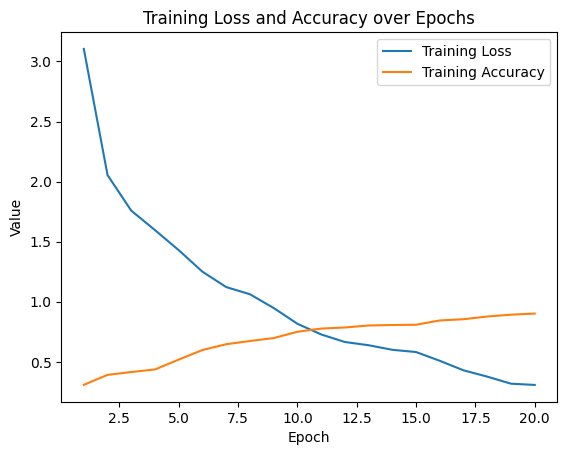

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have the history variable after training:
history = model.fit([train_images, train_question_sequences], np.array(train_label_encoded), epochs=20, batch_size=16)

# Plotting the loss and accuracy on the same graph
epochs = range(1, len(history.history['loss']) + 1)

plt.plot(epochs, history.history['loss'], label='Training Loss')
plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Training Loss and Accuracy over Epochs')
plt.legend()
plt.show()


In [ ]:
test_answers = [item['answer'] for _, item in test_data.items()]

test_label_encoded = [label_mapping[label] for label in test_answers]
test_label_encoded = np.array(test_label_encoded, dtype=np.int32)


In [ ]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate([test_images, test_question_sequences], test_label_encoded)

# Print the test accuracy
print("Test Accuracy:", test_accuracy)

31/31 [==============================] - 172s 5s/step - loss: 0.2385 - accuracy: 0.9170
Test Accuracy: 0.9170082211494446


In [ ]:
# Provide an image and question
input_image_path = '/content/drive/MyDrive/bangla dataset/Images/2.png'
input_question = 'কেউ কি সোফায় বসে আছে?'

# Set the maximum sequence length
max_question_length = 100

# Preprocess the input image
input_image = preprocess_image(input_image_path)
input_image = np.expand_dims(input_image, axis=0)  # Add batch dimension

# Tokenize and preprocess the input question
input_question_sequence = tokenizer.texts_to_sequences([input_question])
input_question_sequence = pad_sequences(input_question_sequence, maxlen=max_question_length)

# Make prediction on the input
prediction = model.predict([input_image, input_question_sequence])
predicted_label = np.argmax(prediction)

# Decode the predicted label
label_mapping_reverse = {v: k for k, v in label_mapping.items()}
predicted_answer = label_mapping_reverse[predicted_label]

# Print the predicted answer
print("Predicted Answer:", predicted_answer)


FileNotFoundError: ignored

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Assuming you have a function preprocess_image() and a tokenizer
# Also, you need to define the label_mapping dictionary and the model

# Function to check if a string is empty or consists of only spaces
def is_empty_or_spaces(s):
    return s.strip() == ""

input_image_path = input("Enter image path: ").strip()
input_question = input("Enter question: ").strip()

# Check if either image path or question is empty
if is_empty_or_spaces(input_image_path) and is_empty_or_spaces(input_question):
    print("Please enter an image path or a question.")
else:
    # Set the maximum sequence length
    max_question_length = 100

    # Preprocess the input image if not empty
    input_image = None
    if not is_empty_or_spaces(input_image_path):
        input_image = preprocess_image(input_image_path)
        input_image = np.expand_dims(input_image, axis=0)  # Add batch dimension

    # Tokenize and preprocess the input question if not empty
    input_question_sequence = None
    if not is_empty_or_spaces(input_question):
        input_question_sequence = tokenizer.texts_to_sequences([input_question])
        if not any(input_question_sequence[0]):  # Check if any valid tokens are present
            print("Invalid question. Please provide a valid question from the dataset.")
            input_question_sequence = None
        else:
            input_question_sequence = pad_sequences(input_question_sequence, maxlen=max_question_length)

    if input_image is not None and input_question_sequence is not None:
        # Make prediction on the input
        prediction = model.predict([input_image, input_question_sequence])
        predicted_label = np.argmax(prediction)

        # Decode the predicted label
        label_mapping_reverse = {v: k for k, v in label_mapping.items()}
        predicted_answer = label_mapping_reverse[predicted_label]

        # Print the predicted answer
        print("Predicted Answer:", predicted_answer)
    else:
        print("Please provide either an image or a question.")
